In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import glob
import json
import torch
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pgf import FigureCanvasPgf
from matplotlib import pyplot as plt
%matplotlib inline

import gb

import tsvar
tsvar.plotting.set_aistat_matplotib_rcparams()

In [2]:
def build_Id(row):
    return os.path.join(os.path.split(row['expId'])[1], row['outputIdx'])

## Choose and Load Experiment

In [3]:
from script_run_exp_vi_varying_prior import build_prior_dict_arr

prior_df = pd.DataFrame(build_prior_dict_arr(N=20))
prior_df['a_mean'] = prior_df['as_pr'] / prior_df['ar_pr']
prior_df['a_var'] = prior_df['as_pr'] / (prior_df['ar_pr'] ** 2)
prior_df['b_mean'] = prior_df['br_pr'] / (prior_df['bs_pr'] - 1)
prior_df['b_var'] = (prior_df['br_pr'] ** 2) / ((prior_df['bs_pr'] - 1) ** 2 * (prior_df['bs_pr'] - 2))
prior_df

,as_pr,ar_pr,bs_pr,br_pr,a_mean,a_var,b_mean,b_var
0,1.0000,10.000,102.000000,101.000000,0.1,0.01,1.0,0.010000
1,1.0000,10.000,63.584821,62.584821,0.1,0.01,1.0,0.016238
2,1.0000,10.000,39.926902,38.926902,0.1,0.01,1.0,0.026367
3,1.0000,10.000,25.357215,24.357215,0.1,0.01,1.0,0.042813
4,1.0000,10.000,16.384499,15.384499,0.1,0.01,1.0,0.069519
...,...,...,...,...,...,...,...,...
395,0.0001,0.001,2.069519,1.069519,0.1,100.00,1.0,14.384499
396,0.0001,0.001,2.042813,1.042813,0.1,100.00,1.0,23.357215
397,0.0001,0.001,2.026367,1.026367,0.1,100.00,1.0,37.926902
398,0.0001,0.001,2.016238,1.016238,0.1,100.00,1.0,61.584821


In [4]:
EXP_DIR = "../output/aistats-rebuttal/varyingPrior-dim10/"
output_df = tsvar.plotting.load_outputs(exp_dir=EXP_DIR)

output_df['prior_idx'] = output_df['outputIdx'].apply(lambda fname: int(fname.rstrip('.json').split('-')[-1]))
output_df = pd.merge(output_df, prior_df, left_on='prior_idx', right_index=True)

assert np.all(output_df['vi_as_pr'] == output_df['as_pr'])
assert np.all(output_df['vi_ar_pr'] == output_df['ar_pr'])
assert np.all(output_df['vi_bs_pr'] == output_df['bs_pr'])
assert np.all(output_df['vi_br_pr'] == output_df['br_pr'])

print(output_df.shape)
#output_df.head()

Process file: ../output/aistats-rebuttal/varyingPrior-dim10/1590697277-g01-d10-n100000/output-01-0297.json...
(2298, 30)


---

Process dataframe for plot

In [5]:
suf_col_dict = {
    'vi': 'vi_adj_mean',
    #'vi': 'vi_adj_mode',
}

augmented_output_df = tsvar.plotting.make_plot_df(output_df, suf_col_dict, agg_col=None, threshold=0.05)

In [6]:
plot_df = augmented_output_df.groupby(['a_var', 'b_var']).agg({
    'relerr_vi': 'mean',
    'log_relerr_vi': 'mean',
    'pr_auc_vi': 'mean',
    'precAt10_vi': 'mean'
})

In [20]:
plot_df

relerr_vi  log_relerr_vi  pr_auc_vi  precAt10_vi
a_var  b_var                                                       
0.01   0.010000     0.145097      -0.838495        1.0          1.0
       0.016238     0.137928      -0.860570        1.0          1.0
       0.026367     0.130583      -0.884355        1.0          1.0
       0.042813     0.122093      -0.913897        1.0          1.0
       0.069519     0.115936      -0.936711        1.0          1.0
...                      ...            ...        ...          ...
100.00 14.384499    0.118745      -0.926197        1.0          1.0
       23.357215    0.119159      -0.924706        1.0          1.0
       37.926902    0.119675      -0.922819        1.0          1.0
       61.584821    0.119594      -0.923157        1.0          1.0
       100.000000   0.119994      -0.921674        1.0          1.0

[400 rows x 4 columns]

Relative Error
[ 0.08  0.10  0.12  0.14  0.16  0.18]
[[ 0.15  0.14  0.13  0.12  0.12  0.11  0.11  0.12  0.12  0.13  0.15  0.16
   0.17  0.17  0.18  0.18  0.19  0.19  0.19  0.19]
 [ 0.14  0.13  0.12  0.11  0.11  0.10  0.10  0.11  0.11  0.12  0.12  0.13
   0.14  0.14  0.14  0.15  0.15  0.15  0.15  0.15]
 [ 0.14  0.13  0.12  0.11  0.10  0.10  0.10  0.10  0.10  0.11  0.11  0.12
   0.12  0.13  0.13  0.13  0.13  0.13  0.13  0.13]
 [ 0.13  0.12  0.11  0.11  0.10  0.09  0.09  0.10  0.10  0.11  0.11  0.11
   0.12  0.12  0.12  0.12  0.12  0.12  0.12  0.12]
 [ 0.13  0.12  0.11  0.10  0.10  0.09  0.09  0.09  0.10  0.10  0.11  0.11
   0.12  0.12  0.12  0.12  0.12  0.12  0.12  0.12]
 [ 0.13  0.12  0.11  0.10  0.09  0.09  0.09  0.09  0.10  0.10  0.11  0.11
   0.11  0.12  0.12  0.12  0.12  0.12  0.12  0.12]
 [ 0.13  0.12  0.11  0.10  0.09  0.09  0.09  0.09  0.10  0.10  0.11  0.11
   0.11  0.12  0.12  0.12  0.12  0.12  0.12  0.12]
 [ 0.13  0.12  0.11  0.10  0.09  0.09  0.09  0.09  0.10  0.10  0.11  0.1

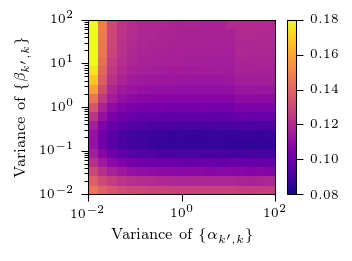

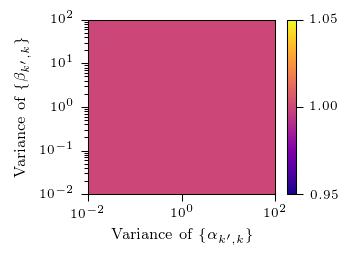

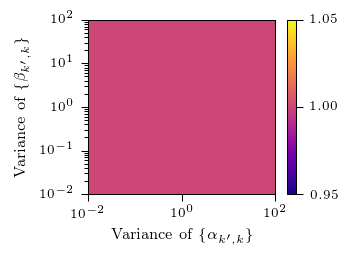

In [37]:
plot_meta_data = [
    ('relerr_vi', 'Relative Error', np.arange(0.08, 0.20, 0.02)),
    ('pr_auc_vi', 'PR-AUC',         np.arange(0.95, 1.05, 0.05)),
    ('precAt10_vi', 'Precision@10', np.arange(0.95, 1.05, 0.05)),
]

exp_name = EXP_DIR.rstrip(os.path.sep).split(os.path.sep)[-1]
output_dir = os.path.join('/Users/trouleau/Desktop/', exp_name)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


for col, label, cbar_ticks in plot_meta_data:
    print(label)
    print(cbar_ticks)
    
    plt.figure(figsize=(1.75 * 4/3, 1.75))
    
    plot_mat = plot_df[col].unstack()

    xarr = np.tile(plot_mat.index, (len(plot_mat.columns), 1)).T  # alpha var value
    yarr = np.tile(plot_mat.columns, (len(plot_mat.index), 1))    # beta var value
    carr = np.array(plot_mat.fillna(plot_mat.mean().mean()))
    
    print(carr)
    
    plt.pcolor(xarr, yarr, carr, cmap='plasma', vmin=cbar_ticks[0], vmax=cbar_ticks[-1])
    plt.colorbar(ticks=cbar_ticks)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(r"Variance of $\{\alpha_{k',k}\}$")
    plt.ylabel(r"Variance of $\{\beta_{k',k}\}$")
    # plt.title(label)
    # plt.text(0.1, 0.1, s=r'$\times$', color='red')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'fig-{exp_name}-{col}.pdf'))